In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import torch 
import pandas as pd
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
tf.debugging.set_log_device_placement(False)
random.seed(9)

In [2]:
os.listdir("/kaggle/input/porn-nonporn-detection/rnn_modelling_data/extracted_frame_features")

['test', 'val', 'train']

In [3]:
path = "/kaggle/input/porn-nonporn-detection/rnn_modelling_data/extracted_frame_features"

In [4]:
save_path = "/kaggle/input/rnn_modelling_data"

In [5]:
human_files_path =  "/kaggle/input/human-presence/train"

In [6]:
human_files_address = [os.path.join(human_files_path, x) for x in  os.listdir(human_files_path) if "_dict" not in x]

In [7]:
print(human_files_address[:5])

['/kaggle/input/human-presence/train/frames_vPorn130.npy', '/kaggle/input/human-presence/train/frames_vPorn117.npy', '/kaggle/input/human-presence/train/frames_vPorn379.npy', '/kaggle/input/human-presence/train/frames_vPorn125.npy', '/kaggle/input/human-presence/train/frames_vPorn112.npy']


In [8]:
train_data = os.path.join(path,"train")
test_data = os.path.join(path,"test")
val_data = os.path.join(path,"val")

In [9]:
class datagen:
    def __init__(self,train_data_path,val_data_path,test_data_path,human_files_path = human_files_address):
        self.train_data_path = train_data_path   ## path for training_data
        self.val_data_path = val_data_path     ## path for validation_data
        self.test_data_path = test_data_path     ## path for test data
        self.batch_size = 8                ###batch size
        self.seq_len =8                  #sequence length of data 
        self.human_files_path = human_files_path   #human files path
        self.human_threshold = 0.4
        
    def val_videos_xy(self):
        porn_add = os.path.join(self.val_data_path,"porn")
        non_porn_add = os.path.join(self.val_data_path,"non_porn")
        porn_list = os.listdir(porn_add)
        non_porn_list  = os.listdir(non_porn_add)
        porn_list = [os.path.join(porn_add,x) for x in porn_list]
        non_porn_list= [os.path.join(non_porn_add,x) for x in non_porn_list]
        
        for i in range(100):
            
            if i<50:
                porn_video = porn_list[i]
                porn = torch.load(porn_video)
                key = list(porn.keys())[0]
                porn = porn[key].numpy()
                video_x = []
                for step in range((porn.shape[0]//self.seq_len)-1):
                    video_sample = porn[step*self.seq_len:step*self.seq_len+self.seq_len]
                    video_x.append(video_sample)
                video_x = np.array(video_x)
                video_x = video_x.reshape((-1,self.seq_len,512))
                video_y = np.ones((video_x.shape[0],))
                yield video_x.reshape((-1,self.seq_len,512,1)),video_y

            elif i>=50:
                non_porn_video = non_porn_list[i%50]
                non_porn = torch.load(non_porn_video)

                key = list(non_porn.keys())[0]
                non_porn = non_porn[key].numpy()

                video_x = []
                for step in range((non_porn.shape[0]//self.seq_len)-1):
                    video_sample = non_porn[step*self.seq_len:step*self.seq_len+self.seq_len]
                    video_x.append(video_sample)
                video_x = np.array(video_x)
                video_x = video_x.reshape((-1,self.seq_len,512))
                video_y = np.zeros((video_x.shape[0],))
                yield video_x.reshape((-1,self.seq_len,512,1)),video_y

        
        
    def test_videos_xy(self):
        porn_add = os.path.join(self.test_data_path,"porn")
        non_porn_add = os.path.join(self.test_data_path,"non_porn")
        porn_list = os.listdir(porn_add)
        non_porn_list  = os.listdir(non_porn_add)
        porn_list = [os.path.join(porn_add,x) for x in porn_list]
        non_porn_list= [os.path.join(non_porn_add,x) for x in non_porn_list]
        
        for i in range(100):
            
            if i<50:
                porn_video = porn_list[i]
                porn = torch.load(porn_video)
                key = list(porn.keys())[0]
                porn = porn[key].numpy()
                video_x = []
                for step in range((porn.shape[0]//self.seq_len)-1):
                    video_sample = porn[step*self.seq_len:step*self.seq_len+self.seq_len]
                    video_x.append(video_sample)
                video_x = np.array(video_x)
                video_x = video_x.reshape((-1,self.seq_len,512))
                video_y = np.ones((video_x.shape[0],))
                yield video_x.reshape((-1,self.seq_len,512,1)),video_y

            elif i>=50:
                non_porn_video = non_porn_list[i%50]
                non_porn = torch.load(non_porn_video)

                key = list(non_porn.keys())[0]
                non_porn = non_porn[key].numpy()

                video_x = []
                for step in range((non_porn.shape[0]//self.seq_len)-1):
                    video_sample = non_porn[step*self.seq_len:step*self.seq_len+self.seq_len]
                    video_x.append(video_sample)
                video_x = np.array(video_x)
                video_x = video_x.reshape((-1,self.seq_len,512))
                video_y = np.zeros((video_x.shape[0],))
                yield video_x.reshape((-1,self.seq_len,512,1)),video_y
            
                
                
    def test_gen(self):  
        porn_add = os.path.join(self.test_data_path,"porn")
        non_porn_add = os.path.join(self.test_data_path,"non_porn")
        porn_list = os.listdir(porn_add)
        non_porn_list  = os.listdir(non_porn_add)
        porn_list = [os.path.join(porn_add,x) for x in porn_list]
        non_porn_list= [os.path.join(non_porn_add,x) for x in non_porn_list]
        random.shuffle(porn_list)
        random.shuffle(non_porn_list)
        
        # start generating data
        for i in range(50):
            #print(porn_list[i],len(porn_list))
            porn_video = porn_list[i]
            non_porn_video = non_porn_list[i]
            
            porn = torch.load(porn_video)
            non_porn = torch.load(non_porn_video)
            
            key = list(porn.keys())[0]
            porn = porn[key].numpy()
            
            key = list(non_porn.keys())[0]
            non_porn = non_porn[key].numpy()
            
            if porn.shape[0]<= self.seq_len and non_porn.shape[0]<=self.seq_len:
                continue
                
            elif porn.shape[0]<=self.batch_size*self.seq_len and non_porn.shape[0]<self.batch_size*self.seq_len:
                try:
                    temp_batch_size = 8

                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= temp_batch_size)
                    np_choice = random.choices(np_indexes,k= temp_batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],1))
                    y_np = np.zeros((batch_np.shape[0],1))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print(batch.shape,y.shape)
                
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*temp_batch_size,))
                except: 
                    continue
                
                
            else:
                try:
                    batch_size = self.batch_size
                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= self.batch_size)
                    np_choice = random.choices(np_indexes,k= self.batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],1))
                    y_np = np.zeros((batch_np.shape[0],1))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print(batch.shape,y.shape)
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*self.batch_size,))
                    
                except:
                    continue


                
    def val_gen(self):
        porn_add = os.path.join(self.val_data_path,"porn")
        non_porn_add = os.path.join(self.val_data_path,"non_porn")
        porn_list = os.listdir(porn_add)
        non_porn_list  = os.listdir(non_porn_add)
        porn_list = [os.path.join(porn_add,x) for x in porn_list]
        non_porn_list= [os.path.join(non_porn_add,x) for x in non_porn_list]
        random.shuffle(porn_list)
        random.shuffle(non_porn_list)
        
        # start generating data
        for i in range(50):
            #print(porn_list[i],len(porn_list))
            porn_video = porn_list[i]
            non_porn_video = non_porn_list[i]
            
            porn = torch.load(porn_video)
            non_porn = torch.load(non_porn_video)
            
            key = list(porn.keys())[0]
            porn = porn[key].numpy()
            
            key = list(non_porn.keys())[0]
            non_porn = non_porn[key].numpy()
            
            if porn.shape[0]<= self.seq_len and non_porn.shape[0]<=self.seq_len:
                continue
                
            elif porn.shape[0]<=self.batch_size*self.seq_len and non_porn.shape[0]<self.batch_size*self.seq_len:
                try:
                    temp_batch_size = 8

                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= temp_batch_size)
                    np_choice = random.choices(np_indexes,k= temp_batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],1))
                    y_np = np.zeros((batch_np.shape[0],1))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print(batch.shape,y.shape)
                
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*temp_batch_size,))
                except: 
                    continue
                
                
            else:
                try:
                    batch_size = self.batch_size
                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= self.batch_size)
                    np_choice = random.choices(np_indexes,k= self.batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],1))
                    y_np = np.zeros((batch_np.shape[0],1))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print(batch.shape,y.shape)
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*self.batch_size,))
                    
                except:
                    continue

 
    def train_gen(self):
        porn_add = os.path.join(self.train_data_path,"porn")
        non_porn_add = os.path.join(self.train_data_path,"non_porn")
        porn_list = os.listdir(porn_add)
        non_porn_list  = os.listdir(non_porn_add)
        porn_list = [os.path.join(porn_add,x) for x in porn_list]
        non_porn_list= [os.path.join(non_porn_add,x) for x in non_porn_list]
        
        self.error_count = 0
        random.shuffle(porn_list)
        random.shuffle(non_porn_list)
        
        human_files_address = self.human_files_path
        human_files_name   = [x.split("/")[-1][:-4] for x in human_files_address]
        threshold = self.human_threshold
        
        skipping_count = 0
        total_count = 0
        # start generating data
        for i in range(300):
            porn_video = porn_list[i]
            non_porn_video = non_porn_list[i]
            ###
            porn_name_pre = porn_video.split("/")[-1]
            porn_name_pre = porn_name_pre[:-3]
            porn_human_file = None
            ###
            porn = torch.load(porn_video)
            non_porn = torch.load(non_porn_video)
            
            key = list(porn.keys())[0]
            porn = porn[key].numpy()
            #####
            if porn_name_pre in human_files_name:
                file_index = human_files_name.index(porn_name_pre)
                porn_human_file = np.load(human_files_address[file_index])
                #porn_human_file = porn_human_file.item()
                porn_human_file = list(porn_human_file)
                if len(porn_human_file)!=porn.shape[0]:
                    porn_human_file = None
                    print("Human Frames Detected were not equal !!!!!!")
            else:
                print(porn_name_pre)
                print(porn_name_pre in human_files_name)
                print(human_files_name)
                print("Human Files Not Detected")
                
            ####    
            
            key = list(non_porn.keys())[0]
            non_porn = non_porn[key].numpy()
            
            if porn.shape[0]<= self.seq_len and non_porn.shape[0]<=self.seq_len:
                continue
                
            elif porn.shape[0]<=self.batch_size*self.seq_len and non_porn.shape[0]< self.batch_size*self.seq_len :
                try:
                    temp_batch_size = 8

                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= temp_batch_size)
                    np_choice = random.choices(np_indexes,k= temp_batch_size)
                    
                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        total_count +=1
                        if porn_human_file == None:
                            pass
                        elif np.average(porn_human_file[t:t+self.seq_len])<self.human_threshold:
                            skipping_count += 1
                            #print("Human Not Found Skipping the frame sequence !!!!")
                            continue
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],))
                    y_np = np.zeros((batch_np.shape[0],))
                    
                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print("ELIF",batch.shape,y.shape)
                
                    #yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*temp_batch_size,))
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((batch_p.shape[0]+batch_np.shape[0],))
                except:
                    continue
                
                
            else:
                try:
                    batch_size = self.batch_size
                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= batch_size)
                    np_choice = random.choices(np_indexes,k= batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        total_count +=1
                        if porn_human_file == None:
                            print("Equal length not detected !!!!")
                            pass
                        elif np.average(porn_human_file[t:t+self.seq_len])<self.human_threshold:
                            skipping_count +=1 
                            #print("Human Not Found Skipping the frame sequence !!!!")
                            continue
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],))
                    y_np = np.zeros((batch_np.shape[0],))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print(batch.shape,y.shape)
                    #yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*batch_size,))
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((batch_p.shape[0]+batch_np.shape[0],))
                except:
                    continue
        print("Skipping_Count : ",skipping_count)
        print("Total Time of loop :",total_count)

In [10]:
gen = datagen(train_data,val_data,test_data)

In [11]:
#Editing Model
model = models.Sequential()
model.add(layers.Conv2D(16,(5,5),padding = "same",activation = "relu",input_shape = (8,512,1)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(32,(5,5),padding = "valid",activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64,(3,5),padding = "valid",activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128,(2,5),padding = "valid",activation = "relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation = "relu"))
model.add(layers.Dense(2,activation= "softmax"))
model.summary()
model.compile( loss = "sparse_categorical_crossentropy",optimizer = optimizers.Adam(learning_rate = 0.0001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 512, 16)        416       
_________________________________________________________________
dropout (Dropout)            (None, 8, 512, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 508, 32)        12832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 508, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 504, 64)        30784     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 504, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 500, 128)       8

In [12]:
def n_fold_accuracy(model,gen,n_folds = 5,type = "test"):
    ten_fold_accuracy = 0.0  
    ten_fold_loss = 0.0
    n_folds = n_folds
    if type == "test":
        for i in range(n_folds):
            total_samples = 0
            total_correct = 0.0
            running_loss = 0.0
            batch_ = 0
            for x,y in gen.test_gen():
                
                batch_ += 1
                met = model.evaluate(x,y,verbose = 0) #for loss we do this 
                y_pred = model.predict(x)
                y_pred = np.argmax(y_pred,axis = 1)
                total_samples += x.shape[0]
                total_correct += np.sum(y_pred==y)
                running_loss += met*x.shape[0]
                
            accuracy_shown = total_correct/np.float(total_samples)
            ten_fold_accuracy += accuracy_shown
            loss_shown  = running_loss/np.float(total_samples)
            ten_fold_loss += loss_shown
        print("%d Fold Test Accuracy : {%.4f} || %d Fold Test Loss : {%.4f}"%(n_folds,ten_fold_accuracy/np.float(n_folds),n_folds,ten_fold_loss/np.float(n_folds)))
        return ten_fold_accuracy/np.float(n_folds),ten_fold_loss/np.float(n_folds)
    else:
        for i in range(n_folds):
            total_samples = 0
            total_correct = 0.0
            running_loss = 0.0
            batch_ = 0
            for x,y in gen.val_gen():
                batch_ += 1
                met = model.evaluate(x,y,verbose = 0) #for loss we do this 
                y_pred = model.predict(x)
                y_pred = np.argmax(y_pred,axis = 1)
                total_samples += x.shape[0]
                total_correct += np.sum(y_pred==y)
                running_loss += met*x.shape[0]
            accuracy_shown = total_correct/np.float(total_samples)
            ten_fold_accuracy += accuracy_shown
            loss_shown  = running_loss/np.float(total_samples)
            ten_fold_loss += loss_shown
        print("%d Fold Validation Accuracy : {%.4f} || %d Fold Validation Loss : {%.4f}"%(n_folds,ten_fold_accuracy/np.float(n_folds),n_folds,ten_fold_loss/np.float(n_folds)))
        return ten_fold_accuracy/np.float(n_folds),ten_fold_loss/np.float(n_folds)
        

In [13]:
def test_videos_acc(model,gen):
    correct_videos = 0
    total_videos = 0
    number  = 0
    for x,y in gen.test_videos_xy():
        try:
            video_label = y[0]    
            number+=1
            #print(number,"-->",x.shape,y.shape)
            total_samples= 0
            total_correct= 0
            total_videos +=1
            met = model.evaluate(x,y,verbose = 0) #for loss we do this 
            y_pred = model.predict(x)
            label_pred = np.argmax(np.mean(y_pred,axis = 0).reshape((1,2)),axis = 1)
            y_pred = np.argmax(y_pred,axis = 1)
            if label_pred==video_label:
                correct_videos += 1
            total_samples += x.shape[0]
            total_correct += np.sum(y_pred==y)
        except:
            continue
        #print("Video {%d} Sequence Prediction Accuracy {%.4f} Sequence Prediction Loss {%.4f} "%(total_videos,total_correct/np.float(total_samples),met)," Video Final Prediction {}".format(label_pred==video_label))
    print("Test Video Classification Acc : {}% ".format((np.float(correct_videos)/np.float(total_videos))*100))
    return (np.float(correct_videos)/np.float(total_videos))*100

In [14]:
def val_videos_acc(model,gen):
    correct_videos = 0
    total_videos = 0
    number  = 0
    for x,y in gen.val_videos_xy():
        try:
            video_label = y[0]    
            number+=1
            #print(number,"-->",x.shape,y.shape)
            total_samples= 0
            total_correct= 0
            total_videos +=1
            met = model.evaluate(x,y,verbose = 0) #for loss we do this 
            y_pred = model.predict(x)
            label_pred = np.argmax(np.mean(y_pred,axis = 0).reshape((1,2)),axis = 1)
            y_pred = np.argmax(y_pred,axis = 1)
            if label_pred==video_label:
                correct_videos += 1
            total_samples += x.shape[0]
            total_correct += np.sum(y_pred==y)
        except:
            continue
        #print("Video {%d} Sequence Prediction Accuracy {%.4f} Sequence Prediction Loss {%.4f} "%(total_videos,total_correct/np.float(total_samples),met)," Video Final Prediction {}".format(label_pred==video_label))
    print("Validation Video Classification Acc : {}% ".format((np.float(correct_videos)/np.float(total_videos))*100))
    return (np.float(correct_videos)/np.float(total_videos))*100

Epoch 1/200
Skipping_Count :  642
Total Time of loop : 2400
training loss : {0.6866} training_acc : {0.5697} 
5 Fold Validation Accuracy : {0.5000} || 5 Fold Validation Loss : {0.6934}
1 Fold Validation Accuracy : {0.5000} || 1 Fold Validation Loss : {0.6934}
Validation Video Classification Acc : 50.0% 
Test Video Classification Acc : 50.0% 
5 Fold Test Accuracy : {0.5000} || 5 Fold Test Loss : {0.6934}
1 Fold Test Accuracy : {0.5000} || 1 Fold Test Loss : {0.6934}
Epoch 2/200
Skipping_Count :  608
Total Time of loop : 2400
training loss : {0.6829} training_acc : {0.5725} 
5 Fold Validation Accuracy : {0.5000} || 5 Fold Validation Loss : {0.6938}
1 Fold Validation Accuracy : {0.5000} || 1 Fold Validation Loss : {0.6938}
Validation Video Classification Acc : 50.0% 
Test Video Classification Acc : 50.0% 
5 Fold Test Accuracy : {0.5000} || 5 Fold Test Loss : {0.6938}
1 Fold Test Accuracy : {0.5000} || 1 Fold Test Loss : {0.6939}
Epoch 3/200
Skipping_Count :  662
Total Time of loop : 2400


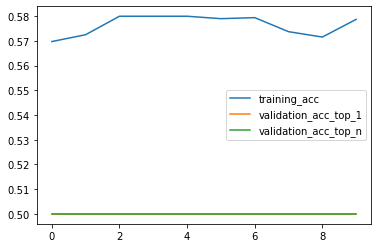

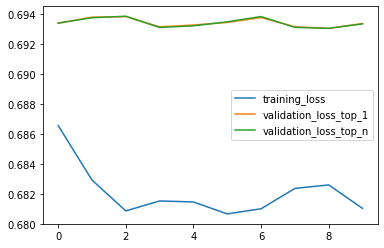

Epoch 11/200
Skipping_Count :  675
Total Time of loop : 2400
training loss : {0.6801} training_acc : {0.5818} 
5 Fold Validation Accuracy : {0.5000} || 5 Fold Validation Loss : {0.6931}
1 Fold Validation Accuracy : {0.5000} || 1 Fold Validation Loss : {0.6932}
Validation Video Classification Acc : 50.0% 
Test Video Classification Acc : 50.0% 
5 Fold Test Accuracy : {0.5000} || 5 Fold Test Loss : {0.6931}
1 Fold Test Accuracy : {0.5000} || 1 Fold Test Loss : {0.6930}
Epoch 12/200
Skipping_Count :  637
Total Time of loop : 2400
training loss : {0.6811} training_acc : {0.5765} 
5 Fold Validation Accuracy : {0.5000} || 5 Fold Validation Loss : {0.6930}
1 Fold Validation Accuracy : {0.5000} || 1 Fold Validation Loss : {0.6929}
Validation Video Classification Acc : 50.0% 
Test Video Classification Acc : 50.0% 
5 Fold Test Accuracy : {0.5000} || 5 Fold Test Loss : {0.6930}
1 Fold Test Accuracy : {0.5000} || 1 Fold Test Loss : {0.6930}
Epoch 13/200
Skipping_Count :  653
Total Time of loop : 24

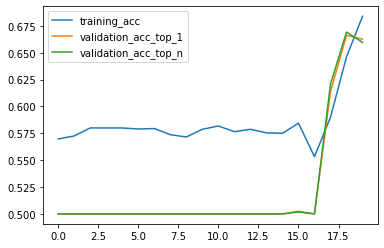

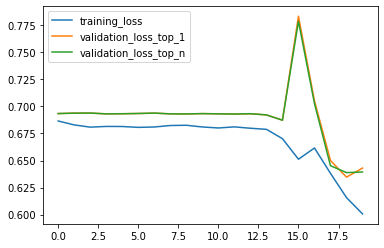

Epoch 21/200
Skipping_Count :  650
Total Time of loop : 2400
training loss : {0.5864} training_acc : {0.7096} 
5 Fold Validation Accuracy : {0.6567} || 5 Fold Validation Loss : {0.6656}
1 Fold Validation Accuracy : {0.6562} || 1 Fold Validation Loss : {0.6633}
Validation Video Classification Acc : 53.0% 
Test Video Classification Acc : 51.0% 
5 Fold Test Accuracy : {0.5757} || 5 Fold Test Loss : {0.7539}
1 Fold Test Accuracy : {0.5663} || 1 Fold Test Loss : {0.7589}
Epoch 22/200
Skipping_Count :  615
Total Time of loop : 2400
training loss : {0.5849} training_acc : {0.7216} 
5 Fold Validation Accuracy : {0.6450} || 5 Fold Validation Loss : {0.6808}
1 Fold Validation Accuracy : {0.6562} || 1 Fold Validation Loss : {0.6858}
Validation Video Classification Acc : 53.0% 
Test Video Classification Acc : 51.0% 
5 Fold Test Accuracy : {0.5677} || 5 Fold Test Loss : {0.8103}
1 Fold Test Accuracy : {0.5700} || 1 Fold Test Loss : {0.8101}
Epoch 23/200
Skipping_Count :  642
Total Time of loop : 24

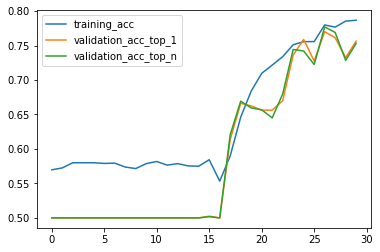

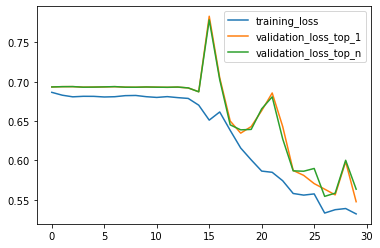

Epoch 31/200
Skipping_Count :  641
Total Time of loop : 2400
training loss : {0.5216} training_acc : {0.7817} 
5 Fold Validation Accuracy : {0.7565} || 5 Fold Validation Loss : {0.5566}
1 Fold Validation Accuracy : {0.7638} || 1 Fold Validation Loss : {0.5542}
Validation Video Classification Acc : 76.0% 
Test Video Classification Acc : 66.0% 
Epoch 32/200
Skipping_Count :  624
Total Time of loop : 2400
training loss : {0.5090} training_acc : {0.7941} 
5 Fold Validation Accuracy : {0.7608} || 5 Fold Validation Loss : {0.5497}
1 Fold Validation Accuracy : {0.7837} || 1 Fold Validation Loss : {0.5536}
Validation Video Classification Acc : 86.0% 
Test Video Classification Acc : 76.0% 
5 Fold Test Accuracy : {0.7028} || 5 Fold Test Loss : {0.6040}
1 Fold Test Accuracy : {0.6750} || 1 Fold Test Loss : {0.6136}
Epoch 33/200
Skipping_Count :  647
Total Time of loop : 2400
training loss : {0.5073} training_acc : {0.8057} 
5 Fold Validation Accuracy : {0.7722} || 5 Fold Validation Loss : {0.5447

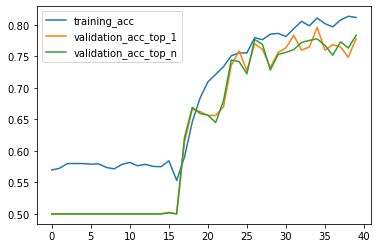

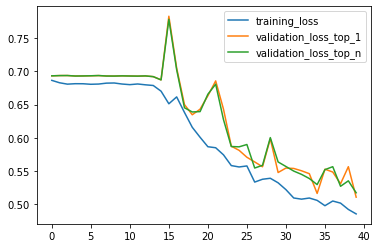

Epoch 41/200
Skipping_Count :  635
Total Time of loop : 2400
training loss : {0.4845} training_acc : {0.8166} 
5 Fold Validation Accuracy : {0.7812} || 5 Fold Validation Loss : {0.5120}
1 Fold Validation Accuracy : {0.8075} || 1 Fold Validation Loss : {0.4937}
Validation Video Classification Acc : 82.0% 
Test Video Classification Acc : 71.0% 
Epoch 42/200
Skipping_Count :  629
Total Time of loop : 2400
training loss : {0.4815} training_acc : {0.8197} 
5 Fold Validation Accuracy : {0.7910} || 5 Fold Validation Loss : {0.5112}
1 Fold Validation Accuracy : {0.7975} || 1 Fold Validation Loss : {0.4970}
Validation Video Classification Acc : 87.0% 
Test Video Classification Acc : 73.0% 
Epoch 43/200
Skipping_Count :  634
Total Time of loop : 2400
training loss : {0.4880} training_acc : {0.8171} 
5 Fold Validation Accuracy : {0.7580} || 5 Fold Validation Loss : {0.5328}
1 Fold Validation Accuracy : {0.7738} || 1 Fold Validation Loss : {0.5208}
Validation Video Classification Acc : 82.0% 
Test

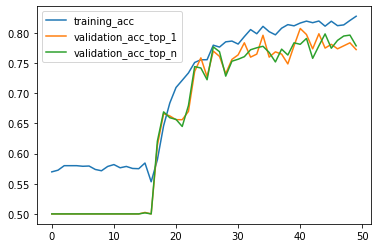

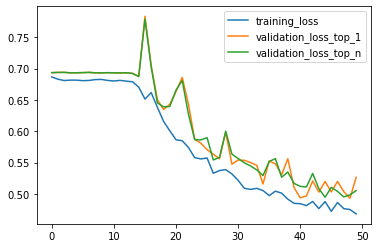

Epoch 51/200
Skipping_Count :  610
Total Time of loop : 2400
training loss : {0.4621} training_acc : {0.8234} 
5 Fold Validation Accuracy : {0.7888} || 5 Fold Validation Loss : {0.5010}
1 Fold Validation Accuracy : {0.7812} || 1 Fold Validation Loss : {0.5028}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 76.0% 
Epoch 52/200
Skipping_Count :  635
Total Time of loop : 2400
training loss : {0.4517} training_acc : {0.8291} 
5 Fold Validation Accuracy : {0.7765} || 5 Fold Validation Loss : {0.5063}
1 Fold Validation Accuracy : {0.7762} || 1 Fold Validation Loss : {0.5015}
Validation Video Classification Acc : 85.0% 
Test Video Classification Acc : 82.0% 
5 Fold Test Accuracy : {0.7085} || 5 Fold Test Loss : {0.5745}
1 Fold Test Accuracy : {0.7412} || 1 Fold Test Loss : {0.5665}
Epoch 53/200
Skipping_Count :  657
Total Time of loop : 2400
training loss : {0.4694} training_acc : {0.8211} 
5 Fold Validation Accuracy : {0.7853} || 5 Fold Validation Loss : {0.4941

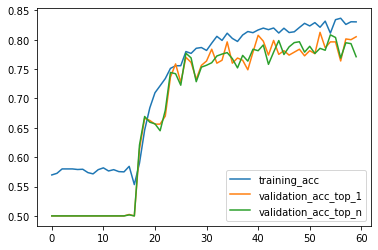

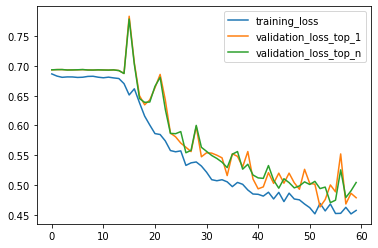

Epoch 61/200
Skipping_Count :  631
Total Time of loop : 2400
training loss : {0.4427} training_acc : {0.8304} 
5 Fold Validation Accuracy : {0.8003} || 5 Fold Validation Loss : {0.4780}
1 Fold Validation Accuracy : {0.8063} || 1 Fold Validation Loss : {0.4705}
Validation Video Classification Acc : 89.0% 
Test Video Classification Acc : 76.0% 
Epoch 62/200
Skipping_Count :  681
Total Time of loop : 2400
training loss : {0.4375} training_acc : {0.8405} 
5 Fold Validation Accuracy : {0.7620} || 5 Fold Validation Loss : {0.5439}
1 Fold Validation Accuracy : {0.7612} || 1 Fold Validation Loss : {0.5459}
Validation Video Classification Acc : 76.0% 
Test Video Classification Acc : 64.0% 
Epoch 63/200
Skipping_Count :  629
Total Time of loop : 2400
training loss : {0.4511} training_acc : {0.8293} 
5 Fold Validation Accuracy : {0.7245} || 5 Fold Validation Loss : {0.5723}
1 Fold Validation Accuracy : {0.7475} || 1 Fold Validation Loss : {0.5666}
Validation Video Classification Acc : 73.0% 
Test

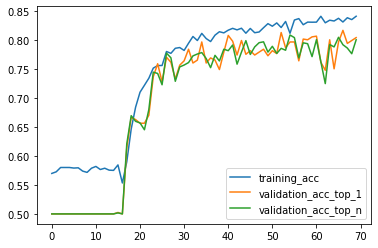

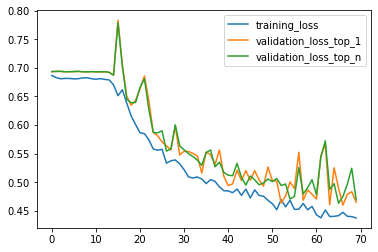

Epoch 71/200
Skipping_Count :  658
Total Time of loop : 2400
training loss : {0.4349} training_acc : {0.8370} 
5 Fold Validation Accuracy : {0.8030} || 5 Fold Validation Loss : {0.4663}
1 Fold Validation Accuracy : {0.8113} || 1 Fold Validation Loss : {0.4653}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 78.0% 
Epoch 72/200
Skipping_Count :  642
Total Time of loop : 2400
training loss : {0.4316} training_acc : {0.8410} 
5 Fold Validation Accuracy : {0.7950} || 5 Fold Validation Loss : {0.4777}
1 Fold Validation Accuracy : {0.7950} || 1 Fold Validation Loss : {0.4598}
Validation Video Classification Acc : 87.0% 
Test Video Classification Acc : 73.0% 
Epoch 73/200
Skipping_Count :  635
Total Time of loop : 2400
training loss : {0.4356} training_acc : {0.8387} 
5 Fold Validation Accuracy : {0.8093} || 5 Fold Validation Loss : {0.4563}
1 Fold Validation Accuracy : {0.8150} || 1 Fold Validation Loss : {0.4505}
Validation Video Classification Acc : 89.0% 
Test

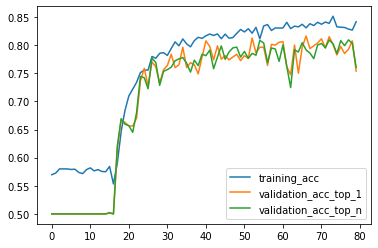

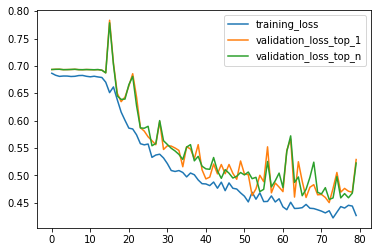

Epoch 81/200
Skipping_Count :  622
Total Time of loop : 2400
training loss : {0.4158} training_acc : {0.8418} 
5 Fold Validation Accuracy : {0.7965} || 5 Fold Validation Loss : {0.4698}
1 Fold Validation Accuracy : {0.7937} || 1 Fold Validation Loss : {0.4522}
Validation Video Classification Acc : 89.0% 
Test Video Classification Acc : 79.0% 
Epoch 82/200
Skipping_Count :  625
Total Time of loop : 2400
training loss : {0.4214} training_acc : {0.8362} 
5 Fold Validation Accuracy : {0.7988} || 5 Fold Validation Loss : {0.4634}
1 Fold Validation Accuracy : {0.8025} || 1 Fold Validation Loss : {0.4790}
Validation Video Classification Acc : 88.0% 
Test Video Classification Acc : 74.0% 
Epoch 83/200
Skipping_Count :  649
Total Time of loop : 2400
training loss : {0.4229} training_acc : {0.8422} 
5 Fold Validation Accuracy : {0.7970} || 5 Fold Validation Loss : {0.4580}
1 Fold Validation Accuracy : {0.8037} || 1 Fold Validation Loss : {0.4559}
Validation Video Classification Acc : 90.0% 
Test

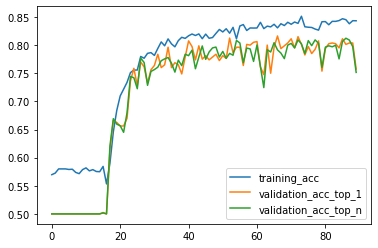

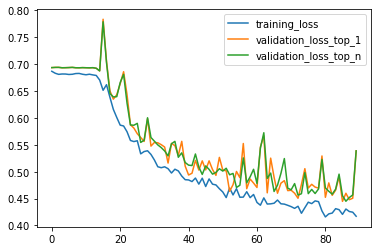

Epoch 91/200
Skipping_Count :  628
Total Time of loop : 2400
training loss : {0.4166} training_acc : {0.8459} 
5 Fold Validation Accuracy : {0.7812} || 5 Fold Validation Loss : {0.4898}
1 Fold Validation Accuracy : {0.7788} || 1 Fold Validation Loss : {0.4839}
Validation Video Classification Acc : 82.0% 
Test Video Classification Acc : 70.0% 
Epoch 92/200
Skipping_Count :  674
Total Time of loop : 2400
training loss : {0.4102} training_acc : {0.8534} 
5 Fold Validation Accuracy : {0.8060} || 5 Fold Validation Loss : {0.4587}
1 Fold Validation Accuracy : {0.8025} || 1 Fold Validation Loss : {0.4655}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 80.0% 
Epoch 93/200
Skipping_Count :  622
Total Time of loop : 2400
training loss : {0.4179} training_acc : {0.8442} 
5 Fold Validation Accuracy : {0.8080} || 5 Fold Validation Loss : {0.4512}
1 Fold Validation Accuracy : {0.8013} || 1 Fold Validation Loss : {0.4645}
Validation Video Classification Acc : 91.0% 
Test

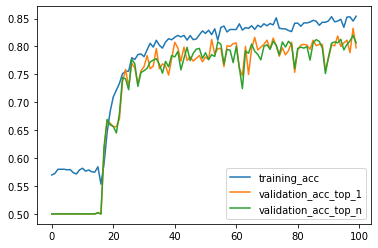

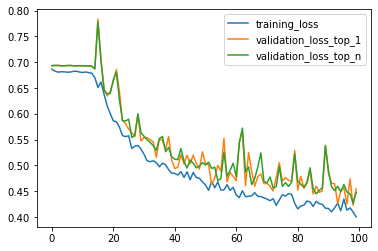

Epoch 101/200
Skipping_Count :  630
Total Time of loop : 2400
training loss : {0.4141} training_acc : {0.8410} 
5 Fold Validation Accuracy : {0.8050} || 5 Fold Validation Loss : {0.4462}
1 Fold Validation Accuracy : {0.8100} || 1 Fold Validation Loss : {0.4334}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 80.0% 
Epoch 102/200
Skipping_Count :  611
Total Time of loop : 2400
training loss : {0.4219} training_acc : {0.8479} 
5 Fold Validation Accuracy : {0.7980} || 5 Fold Validation Loss : {0.4667}
1 Fold Validation Accuracy : {0.8150} || 1 Fold Validation Loss : {0.4476}
Validation Video Classification Acc : 87.0% 
Test Video Classification Acc : 70.0% 
Epoch 103/200
Skipping_Count :  647
Total Time of loop : 2400
training loss : {0.4011} training_acc : {0.8514} 
5 Fold Validation Accuracy : {0.8077} || 5 Fold Validation Loss : {0.4474}
1 Fold Validation Accuracy : {0.8250} || 1 Fold Validation Loss : {0.4161}
Validation Video Classification Acc : 91.0% 
T

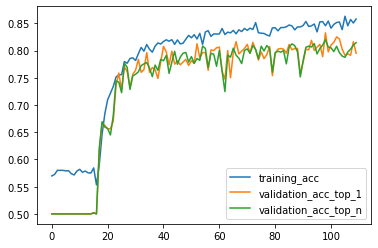

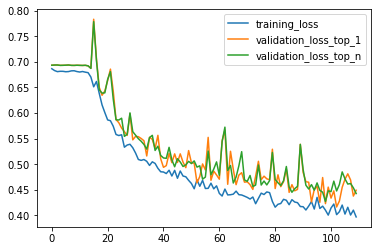

Epoch 111/200
Skipping_Count :  623
Total Time of loop : 2400
training loss : {0.4131} training_acc : {0.8465} 
5 Fold Validation Accuracy : {0.7980} || 5 Fold Validation Loss : {0.4555}
1 Fold Validation Accuracy : {0.7987} || 1 Fold Validation Loss : {0.4479}
Validation Video Classification Acc : 88.0% 
Test Video Classification Acc : 74.0% 
Epoch 112/200
Skipping_Count :  659
Total Time of loop : 2400
training loss : {0.4053} training_acc : {0.8508} 
5 Fold Validation Accuracy : {0.8075} || 5 Fold Validation Loss : {0.4549}
1 Fold Validation Accuracy : {0.8263} || 1 Fold Validation Loss : {0.4334}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 75.0% 
Epoch 113/200
Skipping_Count :  624
Total Time of loop : 2400
training loss : {0.4113} training_acc : {0.8487} 
5 Fold Validation Accuracy : {0.8087} || 5 Fold Validation Loss : {0.4414}
1 Fold Validation Accuracy : {0.8350} || 1 Fold Validation Loss : {0.4087}
Validation Video Classification Acc : 91.0% 
T

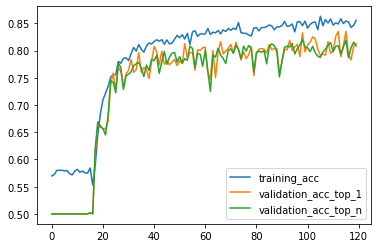

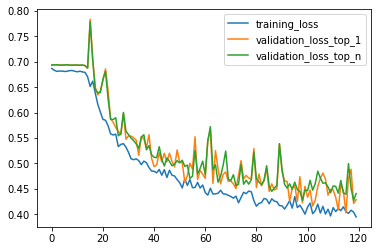

Epoch 121/200
Skipping_Count :  645
Total Time of loop : 2400
training loss : {0.4044} training_acc : {0.8508} 
5 Fold Validation Accuracy : {0.7855} || 5 Fold Validation Loss : {0.4872}
1 Fold Validation Accuracy : {0.7812} || 1 Fold Validation Loss : {0.5103}
Validation Video Classification Acc : 82.0% 
Test Video Classification Acc : 70.0% 
Epoch 122/200
Skipping_Count :  618
Total Time of loop : 2400
training loss : {0.3987} training_acc : {0.8525} 
5 Fold Validation Accuracy : {0.8063} || 5 Fold Validation Loss : {0.4394}
1 Fold Validation Accuracy : {0.8213} || 1 Fold Validation Loss : {0.4265}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 80.0% 
Epoch 123/200
Skipping_Count :  625
Total Time of loop : 2400
training loss : {0.3989} training_acc : {0.8604} 
5 Fold Validation Accuracy : {0.7840} || 5 Fold Validation Loss : {0.4743}
1 Fold Validation Accuracy : {0.8113} || 1 Fold Validation Loss : {0.4702}
Validation Video Classification Acc : 87.0% 
T

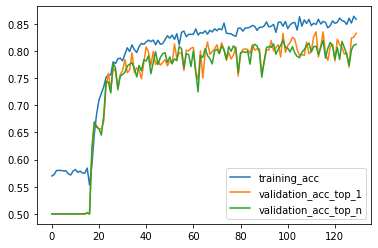

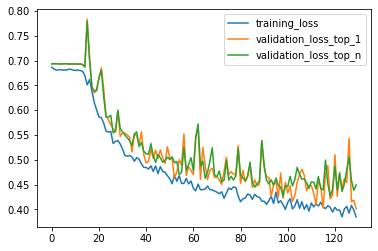

Epoch 131/200
Skipping_Count :  599
Total Time of loop : 2400
training loss : {0.4021} training_acc : {0.8536} 
5 Fold Validation Accuracy : {0.8055} || 5 Fold Validation Loss : {0.4567}
1 Fold Validation Accuracy : {0.7750} || 1 Fold Validation Loss : {0.4915}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 80.0% 
Epoch 132/200
Skipping_Count :  646
Total Time of loop : 2400
training loss : {0.3863} training_acc : {0.8563} 
5 Fold Validation Accuracy : {0.8182} || 5 Fold Validation Loss : {0.4280}
1 Fold Validation Accuracy : {0.8037} || 1 Fold Validation Loss : {0.4470}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 80.0% 
Epoch 133/200
Skipping_Count :  676
Total Time of loop : 2400
training loss : {0.3979} training_acc : {0.8504} 
5 Fold Validation Accuracy : {0.8073} || 5 Fold Validation Loss : {0.4537}
1 Fold Validation Accuracy : {0.8050} || 1 Fold Validation Loss : {0.4548}
Validation Video Classification Acc : 92.0% 
T

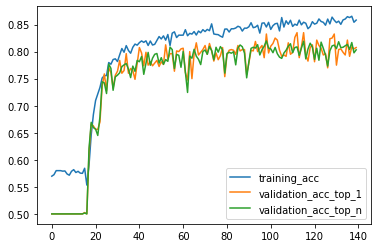

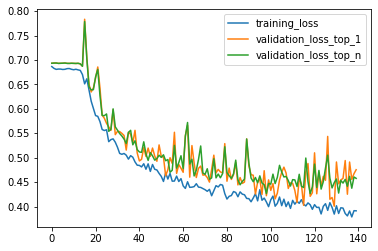

Epoch 141/200
Skipping_Count :  663
Total Time of loop : 2400
training loss : {0.3930} training_acc : {0.8569} 
5 Fold Validation Accuracy : {0.8168} || 5 Fold Validation Loss : {0.4318}
1 Fold Validation Accuracy : {0.8013} || 1 Fold Validation Loss : {0.4365}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 81.0% 
Epoch 142/200
Skipping_Count :  648
Total Time of loop : 2400
training loss : {0.3892} training_acc : {0.8637} 
5 Fold Validation Accuracy : {0.7748} || 5 Fold Validation Loss : {0.5193}
1 Fold Validation Accuracy : {0.7700} || 1 Fold Validation Loss : {0.5434}
Validation Video Classification Acc : 80.0% 
Test Video Classification Acc : 71.0% 
Epoch 143/200
Skipping_Count :  604
Total Time of loop : 2400
training loss : {0.3905} training_acc : {0.8534} 
5 Fold Validation Accuracy : {0.8070} || 5 Fold Validation Loss : {0.4487}
1 Fold Validation Accuracy : {0.8350} || 1 Fold Validation Loss : {0.4176}
Validation Video Classification Acc : 90.0% 
T

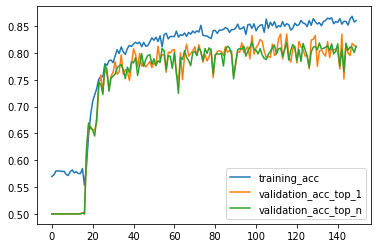

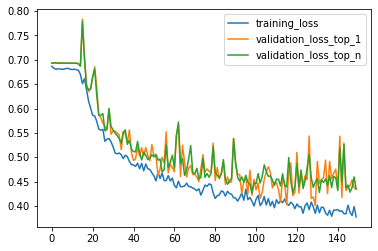

Epoch 151/200
Skipping_Count :  623
Total Time of loop : 2400
training loss : {0.3957} training_acc : {0.8588} 
5 Fold Validation Accuracy : {0.8133} || 5 Fold Validation Loss : {0.4456}
1 Fold Validation Accuracy : {0.8150} || 1 Fold Validation Loss : {0.4206}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 78.0% 
Epoch 152/200
Skipping_Count :  643
Total Time of loop : 2400
training loss : {0.3839} training_acc : {0.8598} 
5 Fold Validation Accuracy : {0.8105} || 5 Fold Validation Loss : {0.4363}
1 Fold Validation Accuracy : {0.8263} || 1 Fold Validation Loss : {0.4016}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 80.0% 
Epoch 153/200
Skipping_Count :  628
Total Time of loop : 2400
training loss : {0.3824} training_acc : {0.8595} 
5 Fold Validation Accuracy : {0.7873} || 5 Fold Validation Loss : {0.4999}
1 Fold Validation Accuracy : {0.7913} || 1 Fold Validation Loss : {0.4792}
Validation Video Classification Acc : 83.0% 
T

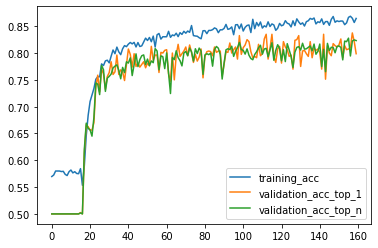

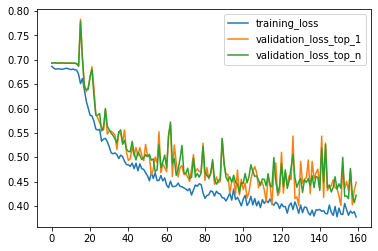

Epoch 161/200
Skipping_Count :  636
Total Time of loop : 2400
training loss : {0.3779} training_acc : {0.8631} 
5 Fold Validation Accuracy : {0.8133} || 5 Fold Validation Loss : {0.4276}
1 Fold Validation Accuracy : {0.8037} || 1 Fold Validation Loss : {0.4414}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 81.0% 
Epoch 162/200
Skipping_Count :  671
Total Time of loop : 2400
training loss : {0.3807} training_acc : {0.8656} 
5 Fold Validation Accuracy : {0.8120} || 5 Fold Validation Loss : {0.4320}
1 Fold Validation Accuracy : {0.8237} || 1 Fold Validation Loss : {0.4273}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 76.0% 
Epoch 163/200
Skipping_Count :  642
Total Time of loop : 2400
training loss : {0.3839} training_acc : {0.8668} 
5 Fold Validation Accuracy : {0.8053} || 5 Fold Validation Loss : {0.4512}
1 Fold Validation Accuracy : {0.7987} || 1 Fold Validation Loss : {0.4477}
Validation Video Classification Acc : 84.0% 
T

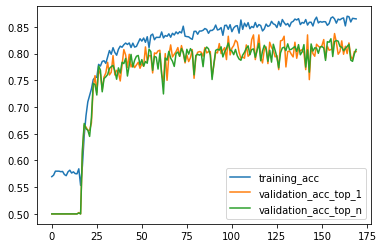

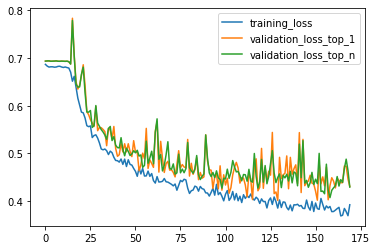

Epoch 171/200
Skipping_Count :  636
Total Time of loop : 2400
training loss : {0.3827} training_acc : {0.8634} 
5 Fold Validation Accuracy : {0.7937} || 5 Fold Validation Loss : {0.4536}
1 Fold Validation Accuracy : {0.7975} || 1 Fold Validation Loss : {0.4174}
Validation Video Classification Acc : 86.0% 
Test Video Classification Acc : 81.0% 
Epoch 172/200
Skipping_Count :  660
Total Time of loop : 2400
training loss : {0.3788} training_acc : {0.8628} 
5 Fold Validation Accuracy : {0.8205} || 5 Fold Validation Loss : {0.4170}
1 Fold Validation Accuracy : {0.8125} || 1 Fold Validation Loss : {0.4109}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 79.0% 
Epoch 173/200
Skipping_Count :  642
Total Time of loop : 2400
training loss : {0.3733} training_acc : {0.8624} 
5 Fold Validation Accuracy : {0.8082} || 5 Fold Validation Loss : {0.4336}
1 Fold Validation Accuracy : {0.8175} || 1 Fold Validation Loss : {0.4220}
Validation Video Classification Acc : 91.0% 
T

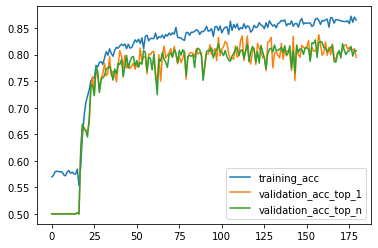

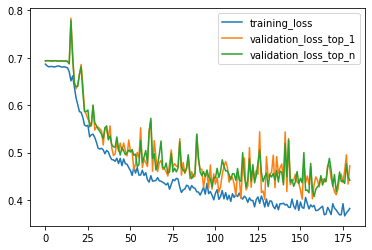

Epoch 181/200
Skipping_Count :  624
Total Time of loop : 2400
training loss : {0.3687} training_acc : {0.8762} 
5 Fold Validation Accuracy : {0.8060} || 5 Fold Validation Loss : {0.4606}
1 Fold Validation Accuracy : {0.8025} || 1 Fold Validation Loss : {0.4631}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 78.0% 
Epoch 182/200
Skipping_Count :  628
Total Time of loop : 2400
training loss : {0.3756} training_acc : {0.8619} 
5 Fold Validation Accuracy : {0.8158} || 5 Fold Validation Loss : {0.4372}
1 Fold Validation Accuracy : {0.8163} || 1 Fold Validation Loss : {0.4141}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 76.0% 
Epoch 183/200
Skipping_Count :  636
Total Time of loop : 2400
training loss : {0.3670} training_acc : {0.8708} 
5 Fold Validation Accuracy : {0.8127} || 5 Fold Validation Loss : {0.4377}
1 Fold Validation Accuracy : {0.8113} || 1 Fold Validation Loss : {0.4226}
Validation Video Classification Acc : 90.0% 
T

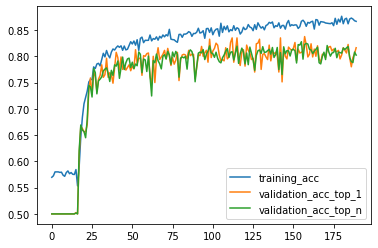

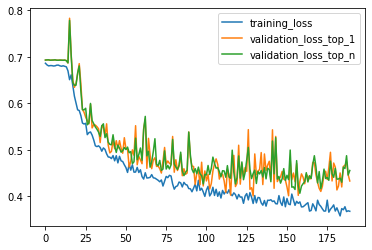

Epoch 191/200
Skipping_Count :  635
Total Time of loop : 2400
training loss : {0.3519} training_acc : {0.8713} 
5 Fold Validation Accuracy : {0.8038} || 5 Fold Validation Loss : {0.4642}
1 Fold Validation Accuracy : {0.8000} || 1 Fold Validation Loss : {0.4965}
Validation Video Classification Acc : 89.0% 
Test Video Classification Acc : 75.0% 
Epoch 192/200
Skipping_Count :  653
Total Time of loop : 2400
training loss : {0.3709} training_acc : {0.8572} 
5 Fold Validation Accuracy : {0.8153} || 5 Fold Validation Loss : {0.4188}
1 Fold Validation Accuracy : {0.7825} || 1 Fold Validation Loss : {0.4672}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 82.0% 
Epoch 193/200
Skipping_Count :  657
Total Time of loop : 2400
training loss : {0.3728} training_acc : {0.8687} 
5 Fold Validation Accuracy : {0.7928} || 5 Fold Validation Loss : {0.4723}
1 Fold Validation Accuracy : {0.7937} || 1 Fold Validation Loss : {0.4866}
Validation Video Classification Acc : 89.0% 
T

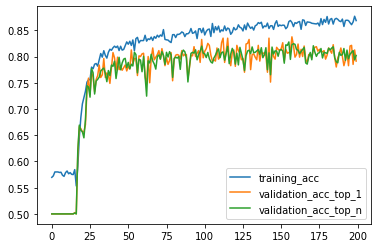

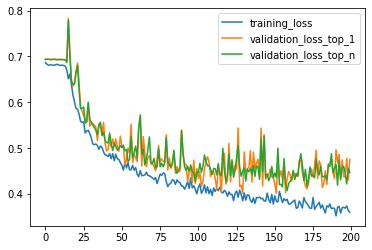

In [15]:
with tf.device("GPU"):
    training_loss_g= []
    training_accuracy_g = []
    validation_accuracy_g_1 = []
    validation_accuracy_g_n = []
    validation_loss_g_1 = []
    validation_loss_g_n = []
    
    max_train_acc = 0.0
    max_val_acc_1 = 0.0
    max_val_acc_n = 0.0
    best_test_class_acc = 0.0
    best_val_classifier = 0.0
    epochs =  200
    for epoch in range(1,epochs+1):
        print("Epoch {}/{}".format(epoch,epochs))
        total_samples = 0
        total_correct = 0.0
        running_loss = 0.0
        batch_ = 0
        for x,y in gen.train_gen():
            batch_ += 1
            met = model.train_on_batch(x,y)
            y_pred = model.predict(x)
            y_pred = np.argmax(y_pred,axis = 1)
            total_samples += x.shape[0]
            total_correct += np.sum(y_pred==y)
            running_loss += met*x.shape[0]
        loss_shown = running_loss/np.float(total_samples)
        accuracy_shown = total_correct/np.float(total_samples)
        training_loss_g.append(loss_shown)
        training_accuracy_g.append(accuracy_shown)
        model.save("/kaggle/working/running_model.h5")
        if accuracy_shown>=max_train_acc:
            max_train_acc = accuracy_shown 
            model.save("/kaggle/working/best_train_acc.h5")
            
        print("training loss : {%.4f} training_acc : {%.4f} "%(loss_shown,accuracy_shown))     
        
        ###################################################################
        val_acc_n,val_loss_n = n_fold_accuracy(model,gen,5,"val")
        ###################################################################
        
        validation_accuracy_g_n.append(val_acc_n)
        validation_loss_g_n.append(val_loss_n)
        
        if max_val_acc_n <=val_acc_n:
            max_val_acc_n = val_acc_n
            model.save("/kaggle/working/best_val_acc_n.h5")
            
        ####################################################################
        val_acc_1,val_loss_1 = n_fold_accuracy(model,gen,1,"val")
        ####################################################################
        
        validation_accuracy_g_1.append(val_acc_1)
        validation_loss_g_1.append(val_loss_1)

        if max_val_acc_1 <=val_acc_1:
            max_val_acc_1 = val_acc_1
            model.save("/kaggle/working/best_val_acc_1.h5")
            
        #####################################################################
        best_val_class=val_videos_acc(model,gen)
        #####################################################################
        
        if best_val_classifier<=best_val_class:
            best_val_classifier = best_val_class
            model.save("/kaggle/working/best_val_classifier.h5")
        
        #####################################################################
        test_class_acc = test_videos_acc(model,gen)
        #####################################################################
        
        if best_test_class_acc<=test_class_acc:
            best_test_class_acc = test_class_acc
            n_fold_accuracy(model,gen,5,"test")
            n_fold_accuracy(model,gen,1,"test")
            model.save("/kaggle/working/best_classifier.h5")
            
        np.save("/kaggle/working/training_loss_g.npy",training_loss_g,allow_pickle = True)
        np.save("/kaggle/working/training_accuracy_g.npy",training_accuracy_g,allow_pickle = True)
        np.save("/kaggle/working/validation_accuracy_g_1.npy",validation_accuracy_g_1,allow_pickle = True)
        np.save("/kaggle/working/validation_accuracy_g_n.npy",validation_accuracy_g_n,allow_pickle = True)
        np.save("/kaggle/working/validation_loss_g_n.npy",validation_loss_g_n,allow_pickle = True)
        np.save("/kaggle/working/validation_loss_g_1.npy",validation_loss_g_1,allow_pickle = True)
        model_state = {
            "max_acc":max_train_acc,
            "max_val_acc_1":max_val_acc_1,
            "max_val_acc_n":max_val_acc_n,
            "best_test_class_acc":best_test_class_acc,
            "best_val_classifier":best_val_classifier,
            "epoch":epoch
        }
        np.save("/kaggle/working/model_state.npy",model_state,allow_pickle = True)


        if epoch%10==0:
            #n_fold_accuracy(model,gen,5,"test")
            #n_fold_accuracy(model,gen,1,"test")
            print("\n")
            try:
                plt.plot(training_accuracy_g,label = "training_acc")
                plt.plot(validation_accuracy_g_1,label = "validation_acc_top_1")
                plt.plot(validation_accuracy_g_n,label = "validation_acc_top_n")
                
                plt.legend()
                plt.show()
                plt.plot(training_loss_g,label = "training_loss")
                plt.plot(validation_loss_g_1,label = "validation_loss_top_1")
                plt.plot(validation_loss_g_n,label = "validation_loss_top_n")
                
                plt.legend()
                plt.show()
            except:
                pass
            

Epoch 201/400
Skipping_Count :  587
Total Time of loop : 2400
training loss : {0.3735} training_acc : {0.8683} 
5 Fold Validation Accuracy : {0.8053} || 5 Fold Validation Loss : {0.4302}
1 Fold Validation Accuracy : {0.7738} || 1 Fold Validation Loss : {0.4789}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 78.0% 
Epoch 202/400
Skipping_Count :  634
Total Time of loop : 2400
training loss : {0.3664} training_acc : {0.8718} 
5 Fold Validation Accuracy : {0.8023} || 5 Fold Validation Loss : {0.4610}
1 Fold Validation Accuracy : {0.8225} || 1 Fold Validation Loss : {0.4243}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 80.0% 
Epoch 203/400
Skipping_Count :  640
Total Time of loop : 2400
training loss : {0.3596} training_acc : {0.8700} 
5 Fold Validation Accuracy : {0.7887} || 5 Fold Validation Loss : {0.4936}
1 Fold Validation Accuracy : {0.7887} || 1 Fold Validation Loss : {0.5077}
Validation Video Classification Acc : 82.0% 
T

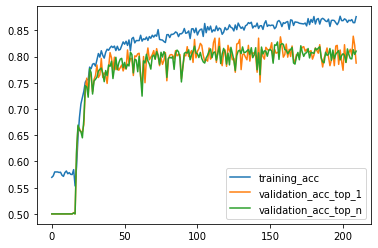

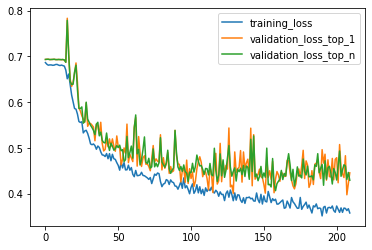

Epoch 211/400
Skipping_Count :  674
Total Time of loop : 2400
training loss : {0.3642} training_acc : {0.8723} 
5 Fold Validation Accuracy : {0.8068} || 5 Fold Validation Loss : {0.4394}
1 Fold Validation Accuracy : {0.8375} || 1 Fold Validation Loss : {0.4100}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 81.0% 
Epoch 212/400
Skipping_Count :  619
Total Time of loop : 2400
training loss : {0.3684} training_acc : {0.8685} 
5 Fold Validation Accuracy : {0.8215} || 5 Fold Validation Loss : {0.4230}
1 Fold Validation Accuracy : {0.8237} || 1 Fold Validation Loss : {0.4217}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 81.0% 
Epoch 213/400
Skipping_Count :  655
Total Time of loop : 2400
training loss : {0.3651} training_acc : {0.8678} 
5 Fold Validation Accuracy : {0.8067} || 5 Fold Validation Loss : {0.4340}
1 Fold Validation Accuracy : {0.8087} || 1 Fold Validation Loss : {0.4349}
Validation Video Classification Acc : 91.0% 
T

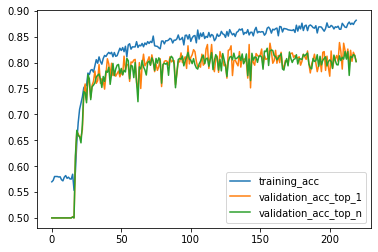

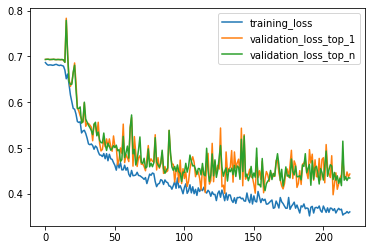

Epoch 221/400
Skipping_Count :  652
Total Time of loop : 2400
training loss : {0.3655} training_acc : {0.8746} 
5 Fold Validation Accuracy : {0.8040} || 5 Fold Validation Loss : {0.4355}
1 Fold Validation Accuracy : {0.8300} || 1 Fold Validation Loss : {0.4187}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 82.0% 
Epoch 222/400
Skipping_Count :  668
Total Time of loop : 2400
training loss : {0.3532} training_acc : {0.8751} 
5 Fold Validation Accuracy : {0.8160} || 5 Fold Validation Loss : {0.4245}
1 Fold Validation Accuracy : {0.8163} || 1 Fold Validation Loss : {0.4357}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 80.0% 
Epoch 223/400
Skipping_Count :  668
Total Time of loop : 2400
training loss : {0.3501} training_acc : {0.8797} 
5 Fold Validation Accuracy : {0.8033} || 5 Fold Validation Loss : {0.4537}
1 Fold Validation Accuracy : {0.8250} || 1 Fold Validation Loss : {0.4357}
Validation Video Classification Acc : 90.0% 
T

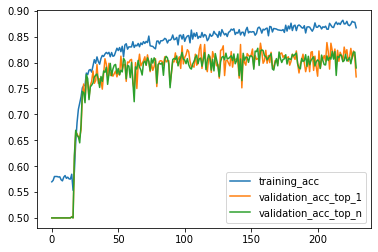

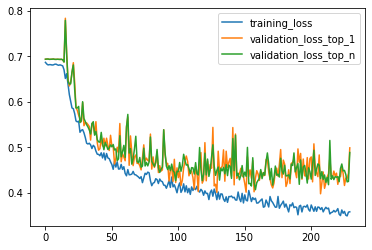

Epoch 231/400
Skipping_Count :  622
Total Time of loop : 2400
training loss : {0.3524} training_acc : {0.8743} 
5 Fold Validation Accuracy : {0.8168} || 5 Fold Validation Loss : {0.4345}
1 Fold Validation Accuracy : {0.8113} || 1 Fold Validation Loss : {0.4534}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 76.0% 
Epoch 232/400
Skipping_Count :  655
Total Time of loop : 2400
training loss : {0.3615} training_acc : {0.8736} 
5 Fold Validation Accuracy : {0.8170} || 5 Fold Validation Loss : {0.4257}
1 Fold Validation Accuracy : {0.8163} || 1 Fold Validation Loss : {0.3967}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 80.0% 
Epoch 233/400
Skipping_Count :  630
Total Time of loop : 2400
training loss : {0.3655} training_acc : {0.8669} 
5 Fold Validation Accuracy : {0.8162} || 5 Fold Validation Loss : {0.4305}
1 Fold Validation Accuracy : {0.8063} || 1 Fold Validation Loss : {0.4356}
Validation Video Classification Acc : 92.0% 
T

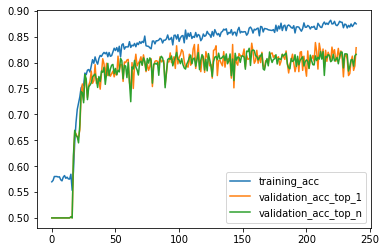

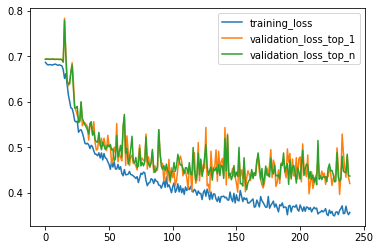

Epoch 241/400
Skipping_Count :  623
Total Time of loop : 2400
training loss : {0.3523} training_acc : {0.8791} 
5 Fold Validation Accuracy : {0.8055} || 5 Fold Validation Loss : {0.4844}
1 Fold Validation Accuracy : {0.7913} || 1 Fold Validation Loss : {0.5009}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 72.0% 
Epoch 242/400
Skipping_Count :  621
Total Time of loop : 2400
training loss : {0.3646} training_acc : {0.8691} 
5 Fold Validation Accuracy : {0.8015} || 5 Fold Validation Loss : {0.4429}
1 Fold Validation Accuracy : {0.8250} || 1 Fold Validation Loss : {0.4121}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 79.0% 
Epoch 243/400
Skipping_Count :  672
Total Time of loop : 2400
training loss : {0.3485} training_acc : {0.8798} 
5 Fold Validation Accuracy : {0.8158} || 5 Fold Validation Loss : {0.4337}
1 Fold Validation Accuracy : {0.8100} || 1 Fold Validation Loss : {0.4189}
Validation Video Classification Acc : 91.0% 
T

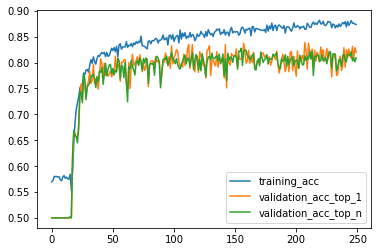

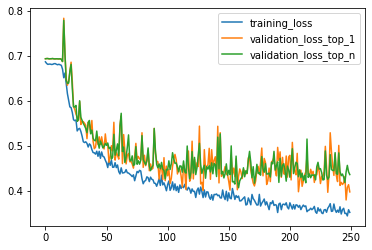

Epoch 251/400
Skipping_Count :  601
Total Time of loop : 2400
training loss : {0.3490} training_acc : {0.8738} 
5 Fold Validation Accuracy : {0.8220} || 5 Fold Validation Loss : {0.4247}
1 Fold Validation Accuracy : {0.8275} || 1 Fold Validation Loss : {0.4083}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 76.0% 
Epoch 252/400
Skipping_Count :  645
Total Time of loop : 2400
training loss : {0.3550} training_acc : {0.8734} 
5 Fold Validation Accuracy : {0.8197} || 5 Fold Validation Loss : {0.4252}
1 Fold Validation Accuracy : {0.8187} || 1 Fold Validation Loss : {0.4021}
Validation Video Classification Acc : 93.0% 
Test Video Classification Acc : 76.0% 
Epoch 253/400
Skipping_Count :  641
Total Time of loop : 2400
training loss : {0.3413} training_acc : {0.8841} 
5 Fold Validation Accuracy : {0.7985} || 5 Fold Validation Loss : {0.4623}
1 Fold Validation Accuracy : {0.7800} || 1 Fold Validation Loss : {0.5083}
Validation Video Classification Acc : 90.0% 
T

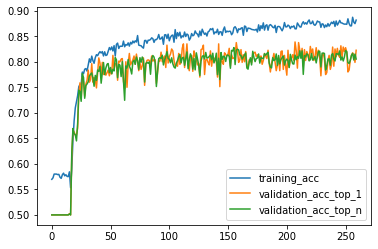

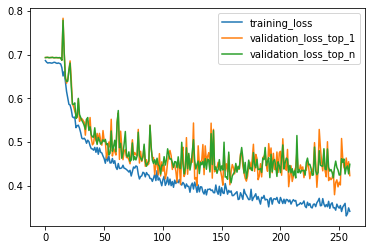

Epoch 261/400
Skipping_Count :  612
Total Time of loop : 2400
training loss : {0.3639} training_acc : {0.8756} 
5 Fold Validation Accuracy : {0.8080} || 5 Fold Validation Loss : {0.4360}
1 Fold Validation Accuracy : {0.8125} || 1 Fold Validation Loss : {0.4409}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 77.0% 
Epoch 262/400
Skipping_Count :  650
Total Time of loop : 2400
training loss : {0.3461} training_acc : {0.8752} 
5 Fold Validation Accuracy : {0.7897} || 5 Fold Validation Loss : {0.5069}
1 Fold Validation Accuracy : {0.7987} || 1 Fold Validation Loss : {0.5051}
Validation Video Classification Acc : 82.0% 
Test Video Classification Acc : 72.0% 
Epoch 263/400
Skipping_Count :  661
Total Time of loop : 2400
training loss : {0.3546} training_acc : {0.8717} 
5 Fold Validation Accuracy : {0.8082} || 5 Fold Validation Loss : {0.4318}
1 Fold Validation Accuracy : {0.7987} || 1 Fold Validation Loss : {0.4529}
Validation Video Classification Acc : 91.0% 
T

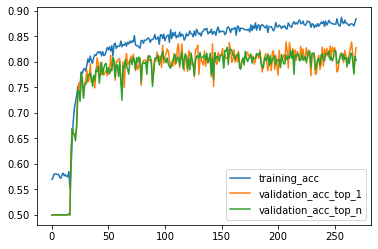

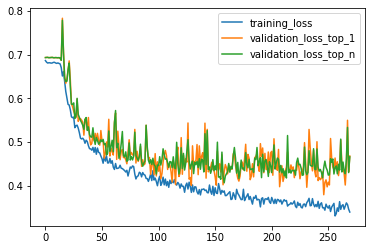

Epoch 271/400
Skipping_Count :  678
Total Time of loop : 2400
training loss : {0.3315} training_acc : {0.8869} 
5 Fold Validation Accuracy : {0.8012} || 5 Fold Validation Loss : {0.4871}
1 Fold Validation Accuracy : {0.7950} || 1 Fold Validation Loss : {0.4708}
Validation Video Classification Acc : 89.0% 
Test Video Classification Acc : 72.0% 
Epoch 272/400
Skipping_Count :  635
Total Time of loop : 2400
training loss : {0.3530} training_acc : {0.8821} 
5 Fold Validation Accuracy : {0.8088} || 5 Fold Validation Loss : {0.4369}
1 Fold Validation Accuracy : {0.8087} || 1 Fold Validation Loss : {0.4421}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 80.0% 
Epoch 273/400
Skipping_Count :  629
Total Time of loop : 2400
training loss : {0.3550} training_acc : {0.8732} 
5 Fold Validation Accuracy : {0.8148} || 5 Fold Validation Loss : {0.4278}
1 Fold Validation Accuracy : {0.8025} || 1 Fold Validation Loss : {0.4480}
Validation Video Classification Acc : 91.0% 
T

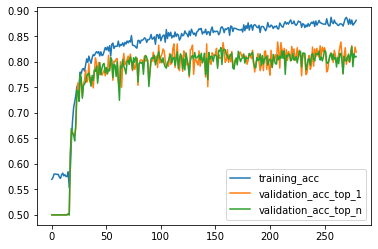

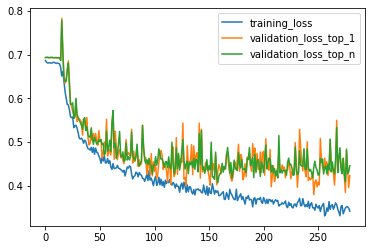

Epoch 281/400
Skipping_Count :  638
Total Time of loop : 2400
training loss : {0.3453} training_acc : {0.8724} 
5 Fold Validation Accuracy : {0.8008} || 5 Fold Validation Loss : {0.4378}
1 Fold Validation Accuracy : {0.7900} || 1 Fold Validation Loss : {0.4545}
Validation Video Classification Acc : 86.0% 
Test Video Classification Acc : 82.0% 
Epoch 282/400
Skipping_Count :  637
Total Time of loop : 2400
training loss : {0.3477} training_acc : {0.8830} 
5 Fold Validation Accuracy : {0.8080} || 5 Fold Validation Loss : {0.4395}
1 Fold Validation Accuracy : {0.8187} || 1 Fold Validation Loss : {0.4222}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 78.0% 
Epoch 283/400
Skipping_Count :  633
Total Time of loop : 2400
training loss : {0.3342} training_acc : {0.8826} 
5 Fold Validation Accuracy : {0.7977} || 5 Fold Validation Loss : {0.4799}
1 Fold Validation Accuracy : {0.8125} || 1 Fold Validation Loss : {0.4932}
Validation Video Classification Acc : 91.0% 
T

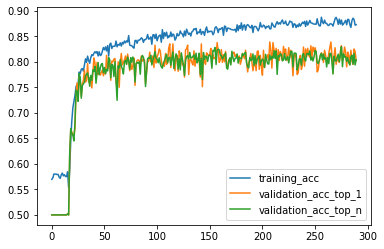

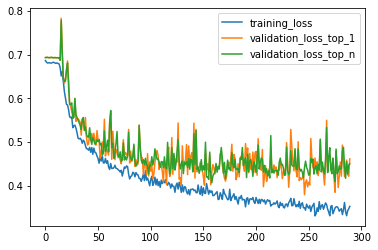

Epoch 291/400
Skipping_Count :  650
Total Time of loop : 2400
training loss : {0.3347} training_acc : {0.8855} 
5 Fold Validation Accuracy : {0.8055} || 5 Fold Validation Loss : {0.4409}
1 Fold Validation Accuracy : {0.7963} || 1 Fold Validation Loss : {0.4613}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 82.0% 
Epoch 292/400
Skipping_Count :  618
Total Time of loop : 2400
training loss : {0.3590} training_acc : {0.8721} 
5 Fold Validation Accuracy : {0.7843} || 5 Fold Validation Loss : {0.4522}
1 Fold Validation Accuracy : {0.7963} || 1 Fold Validation Loss : {0.4455}
Validation Video Classification Acc : 85.0% 
Test Video Classification Acc : 82.0% 
Epoch 293/400
Skipping_Count :  610
Total Time of loop : 2400
training loss : {0.3536} training_acc : {0.8745} 
5 Fold Validation Accuracy : {0.7948} || 5 Fold Validation Loss : {0.4468}
1 Fold Validation Accuracy : {0.8350} || 1 Fold Validation Loss : {0.4095}
Validation Video Classification Acc : 84.0% 
T

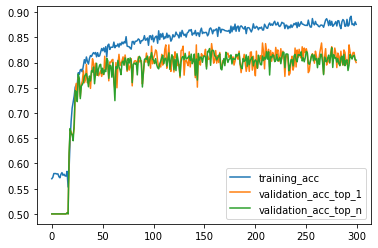

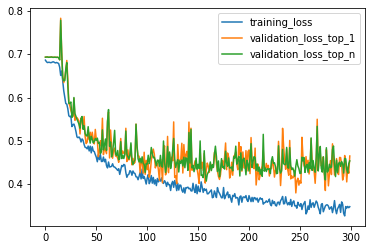

Epoch 301/400
Skipping_Count :  628
Total Time of loop : 2400
training loss : {0.3180} training_acc : {0.8919} 
5 Fold Validation Accuracy : {0.8085} || 5 Fold Validation Loss : {0.4480}
1 Fold Validation Accuracy : {0.8125} || 1 Fold Validation Loss : {0.4905}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 74.0% 
Epoch 302/400
Skipping_Count :  631
Total Time of loop : 2400
training loss : {0.3490} training_acc : {0.8796} 
5 Fold Validation Accuracy : {0.8133} || 5 Fold Validation Loss : {0.4350}
1 Fold Validation Accuracy : {0.7875} || 1 Fold Validation Loss : {0.4410}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 82.0% 
Epoch 303/400
Skipping_Count :  662
Total Time of loop : 2400
training loss : {0.3545} training_acc : {0.8726} 
5 Fold Validation Accuracy : {0.8040} || 5 Fold Validation Loss : {0.4455}
1 Fold Validation Accuracy : {0.8137} || 1 Fold Validation Loss : {0.4061}
Validation Video Classification Acc : 90.0% 
T

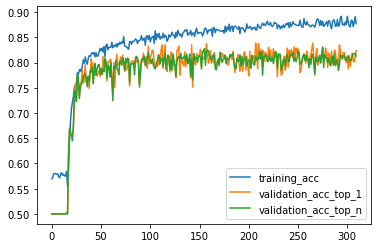

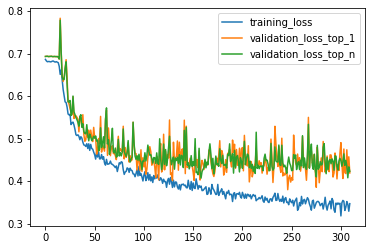

Epoch 311/400
Skipping_Count :  602
Total Time of loop : 2400
training loss : {0.3380} training_acc : {0.8833} 
5 Fold Validation Accuracy : {0.8125} || 5 Fold Validation Loss : {0.4356}
1 Fold Validation Accuracy : {0.8125} || 1 Fold Validation Loss : {0.4489}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 77.0% 
Epoch 312/400
Skipping_Count :  640
Total Time of loop : 2400
training loss : {0.3360} training_acc : {0.8803} 
5 Fold Validation Accuracy : {0.8162} || 5 Fold Validation Loss : {0.4306}
1 Fold Validation Accuracy : {0.8050} || 1 Fold Validation Loss : {0.4375}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 78.0% 
Epoch 313/400
Skipping_Count :  629
Total Time of loop : 2400
training loss : {0.3285} training_acc : {0.8892} 
5 Fold Validation Accuracy : {0.8115} || 5 Fold Validation Loss : {0.4445}
1 Fold Validation Accuracy : {0.8213} || 1 Fold Validation Loss : {0.4243}
Validation Video Classification Acc : 91.0% 
T

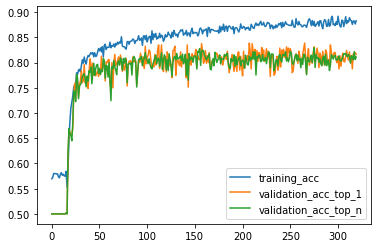

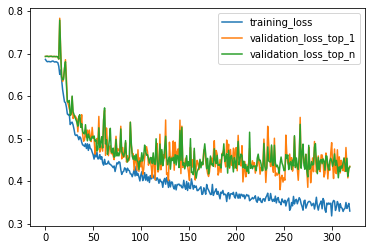

Epoch 321/400
Skipping_Count :  645
Total Time of loop : 2400
training loss : {0.3499} training_acc : {0.8748} 
5 Fold Validation Accuracy : {0.8110} || 5 Fold Validation Loss : {0.4399}
1 Fold Validation Accuracy : {0.8150} || 1 Fold Validation Loss : {0.4418}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 76.0% 
Epoch 322/400
Skipping_Count :  637
Total Time of loop : 2400
training loss : {0.3221} training_acc : {0.8881} 
5 Fold Validation Accuracy : {0.8003} || 5 Fold Validation Loss : {0.4583}
1 Fold Validation Accuracy : {0.7925} || 1 Fold Validation Loss : {0.4604}
Validation Video Classification Acc : 85.0% 
Test Video Classification Acc : 83.0% 
5 Fold Test Accuracy : {0.7255} || 5 Fold Test Loss : {0.5950}
1 Fold Test Accuracy : {0.7250} || 1 Fold Test Loss : {0.6015}
Epoch 323/400
Skipping_Count :  667
Total Time of loop : 2400
training loss : {0.3512} training_acc : {0.8771} 
5 Fold Validation Accuracy : {0.8107} || 5 Fold Validation Loss : {0.4

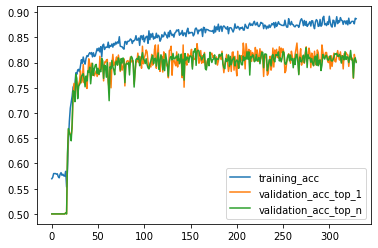

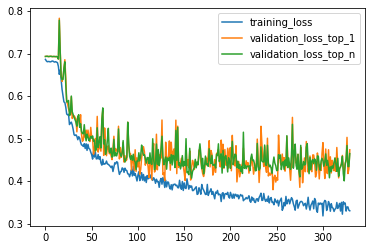

Epoch 331/400
Skipping_Count :  656
Total Time of loop : 2400
training loss : {0.3312} training_acc : {0.8827} 
5 Fold Validation Accuracy : {0.8102} || 5 Fold Validation Loss : {0.4432}
1 Fold Validation Accuracy : {0.8250} || 1 Fold Validation Loss : {0.4457}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 76.0% 
Epoch 332/400
Skipping_Count :  654
Total Time of loop : 2400
training loss : {0.3370} training_acc : {0.8886} 
5 Fold Validation Accuracy : {0.8102} || 5 Fold Validation Loss : {0.4269}
1 Fold Validation Accuracy : {0.8025} || 1 Fold Validation Loss : {0.4360}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 78.0% 
Epoch 333/400
Skipping_Count :  633
Total Time of loop : 2400
training loss : {0.3377} training_acc : {0.8855} 
5 Fold Validation Accuracy : {0.8017} || 5 Fold Validation Loss : {0.4374}
1 Fold Validation Accuracy : {0.8300} || 1 Fold Validation Loss : {0.4057}
Validation Video Classification Acc : 91.0% 
T

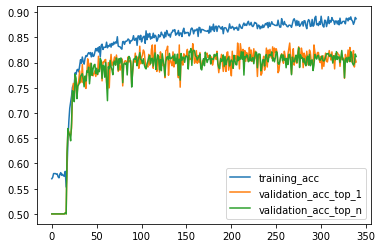

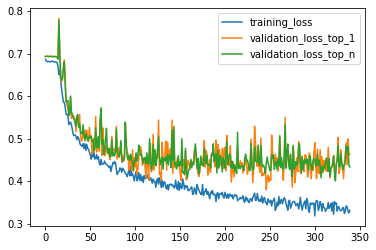

Epoch 341/400
Skipping_Count :  660
Total Time of loop : 2400
training loss : {0.3342} training_acc : {0.8872} 
5 Fold Validation Accuracy : {0.8137} || 5 Fold Validation Loss : {0.4220}
1 Fold Validation Accuracy : {0.7925} || 1 Fold Validation Loss : {0.4436}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 82.0% 
Epoch 342/400
Skipping_Count :  629
Total Time of loop : 2400
training loss : {0.3297} training_acc : {0.8816} 
5 Fold Validation Accuracy : {0.7943} || 5 Fold Validation Loss : {0.4376}
1 Fold Validation Accuracy : {0.7925} || 1 Fold Validation Loss : {0.4342}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 81.0% 
Epoch 343/400
Skipping_Count :  621
Total Time of loop : 2400
training loss : {0.3333} training_acc : {0.8899} 
5 Fold Validation Accuracy : {0.8100} || 5 Fold Validation Loss : {0.4512}
1 Fold Validation Accuracy : {0.8200} || 1 Fold Validation Loss : {0.4190}
Validation Video Classification Acc : 91.0% 
T

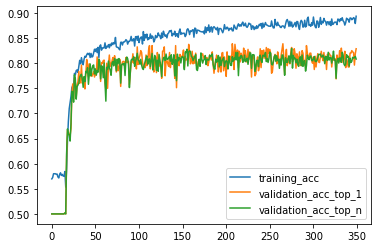

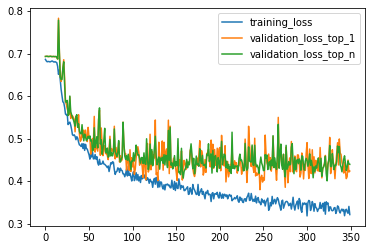

Epoch 351/400
Skipping_Count :  639
Total Time of loop : 2400
training loss : {0.3322} training_acc : {0.8897} 
5 Fold Validation Accuracy : {0.8008} || 5 Fold Validation Loss : {0.4574}
1 Fold Validation Accuracy : {0.7975} || 1 Fold Validation Loss : {0.4730}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 78.0% 
Epoch 352/400
Skipping_Count :  617
Total Time of loop : 2400
training loss : {0.3388} training_acc : {0.8860} 
5 Fold Validation Accuracy : {0.8097} || 5 Fold Validation Loss : {0.4348}
1 Fold Validation Accuracy : {0.8063} || 1 Fold Validation Loss : {0.4361}
Validation Video Classification Acc : 92.0% 
Test Video Classification Acc : 79.0% 
Epoch 353/400
Skipping_Count :  609
Total Time of loop : 2400
training loss : {0.3293} training_acc : {0.8895} 
5 Fold Validation Accuracy : {0.8027} || 5 Fold Validation Loss : {0.4520}
1 Fold Validation Accuracy : {0.8137} || 1 Fold Validation Loss : {0.4326}
Validation Video Classification Acc : 92.0% 
T

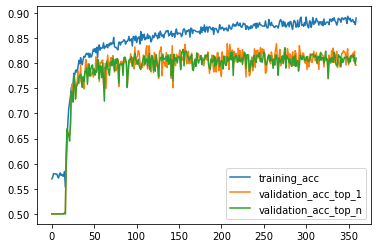

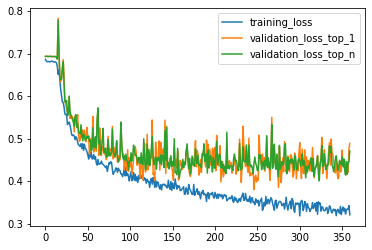

Epoch 361/400
Skipping_Count :  664
Total Time of loop : 2400
training loss : {0.3415} training_acc : {0.8791} 
5 Fold Validation Accuracy : {0.8073} || 5 Fold Validation Loss : {0.4345}
1 Fold Validation Accuracy : {0.8263} || 1 Fold Validation Loss : {0.4083}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 76.0% 
Epoch 362/400
Skipping_Count :  618
Total Time of loop : 2400
training loss : {0.3201} training_acc : {0.8883} 
5 Fold Validation Accuracy : {0.8043} || 5 Fold Validation Loss : {0.4422}
1 Fold Validation Accuracy : {0.8050} || 1 Fold Validation Loss : {0.4259}
Validation Video Classification Acc : 88.0% 
Test Video Classification Acc : 82.0% 
Epoch 363/400
Skipping_Count :  627
Total Time of loop : 2400
training loss : {0.3234} training_acc : {0.8876} 
5 Fold Validation Accuracy : {0.8037} || 5 Fold Validation Loss : {0.4471}
1 Fold Validation Accuracy : {0.8175} || 1 Fold Validation Loss : {0.4101}
Validation Video Classification Acc : 93.0% 
T

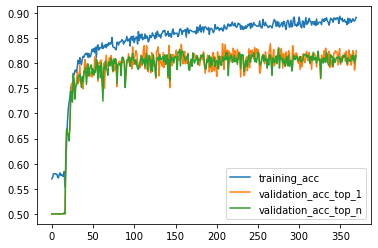

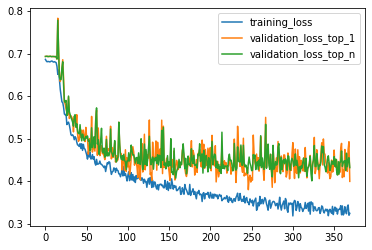

Epoch 371/400
Skipping_Count :  630
Total Time of loop : 2400
training loss : {0.3320} training_acc : {0.8851} 
5 Fold Validation Accuracy : {0.8057} || 5 Fold Validation Loss : {0.4568}
1 Fold Validation Accuracy : {0.8087} || 1 Fold Validation Loss : {0.4589}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 76.0% 
Epoch 372/400
Skipping_Count :  656
Total Time of loop : 2400
training loss : {0.3306} training_acc : {0.8885} 
5 Fold Validation Accuracy : {0.8085} || 5 Fold Validation Loss : {0.4392}
1 Fold Validation Accuracy : {0.8063} || 1 Fold Validation Loss : {0.4668}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 82.0% 
Epoch 373/400
Skipping_Count :  644
Total Time of loop : 2400
training loss : {0.3506} training_acc : {0.8742} 
5 Fold Validation Accuracy : {0.8117} || 5 Fold Validation Loss : {0.4331}
1 Fold Validation Accuracy : {0.7837} || 1 Fold Validation Loss : {0.4591}
Validation Video Classification Acc : 91.0% 
T

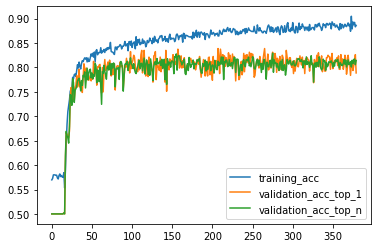

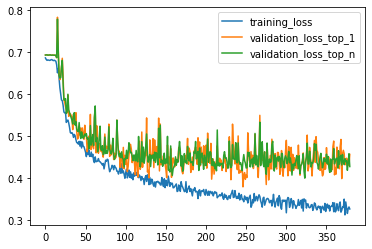

Epoch 381/400
Skipping_Count :  629
Total Time of loop : 2400
training loss : {0.3256} training_acc : {0.8835} 
5 Fold Validation Accuracy : {0.8070} || 5 Fold Validation Loss : {0.4360}
1 Fold Validation Accuracy : {0.8113} || 1 Fold Validation Loss : {0.4207}
Validation Video Classification Acc : 91.0% 
Test Video Classification Acc : 81.0% 
Epoch 382/400
Skipping_Count :  623
Total Time of loop : 2400
training loss : {0.3298} training_acc : {0.8853} 
5 Fold Validation Accuracy : {0.8180} || 5 Fold Validation Loss : {0.4199}
1 Fold Validation Accuracy : {0.8125} || 1 Fold Validation Loss : {0.4368}
Validation Video Classification Acc : 90.0% 
Test Video Classification Acc : 81.0% 
Epoch 383/400


In [ ]:
with tf.device("GPU"):
    #training_loss_g= []
    #training_accuracy_g = []
    #validation_accuracy_g_1 = []
    #validation_accuracy_g_n = []
    #validation_loss_g_1 = []
    #validation_loss_g_n = []
    
    #max_train_acc = 0.0
    #max_val_acc_1 = 0.0
    #max_val_acc_n = 0.0
    #best_test_class_acc = 0.0
    #best_val_classifier = 0.0
    epochs =  400
    for epoch in range(201,epochs+1):
        print("Epoch {}/{}".format(epoch,epochs))
        total_samples = 0
        total_correct = 0.0
        running_loss = 0.0
        batch_ = 0
        for x,y in gen.train_gen():
            batch_ += 1
            met = model.train_on_batch(x,y)
            y_pred = model.predict(x)
            y_pred = np.argmax(y_pred,axis = 1)
            total_samples += x.shape[0]
            total_correct += np.sum(y_pred==y)
            running_loss += met*x.shape[0]
        loss_shown = running_loss/np.float(total_samples)
        accuracy_shown = total_correct/np.float(total_samples)
        training_loss_g.append(loss_shown)
        training_accuracy_g.append(accuracy_shown)
        model.save("/kaggle/working/running_model.h5")
        if accuracy_shown>=max_train_acc:
            max_train_acc = accuracy_shown 
            model.save("/kaggle/working/best_train_acc.h5")
            
        print("training loss : {%.4f} training_acc : {%.4f} "%(loss_shown,accuracy_shown))     
        
        ###################################################################
        val_acc_n,val_loss_n = n_fold_accuracy(model,gen,5,"val")
        ###################################################################
        
        validation_accuracy_g_n.append(val_acc_n)
        validation_loss_g_n.append(val_loss_n)
        
        if max_val_acc_n <=val_acc_n:
            max_val_acc_n = val_acc_n
            model.save("/kaggle/working/best_val_acc_n.h5")
            
        ####################################################################
        val_acc_1,val_loss_1 = n_fold_accuracy(model,gen,1,"val")
        ####################################################################
        
        validation_accuracy_g_1.append(val_acc_1)
        validation_loss_g_1.append(val_loss_1)

        if max_val_acc_1 <=val_acc_1:
            max_val_acc_1 = val_acc_1
            model.save("/kaggle/working/best_val_acc_1.h5")
            
        #####################################################################
        best_val_class=val_videos_acc(model,gen)
        #####################################################################
        
        if best_val_classifier<=best_val_class:
            best_val_classifier = best_val_class
            model.save("/kaggle/working/best_val_classifier.h5")
        
        #####################################################################
        test_class_acc = test_videos_acc(model,gen)
        #####################################################################
        
        if best_test_class_acc<=test_class_acc:
            best_test_class_acc = test_class_acc
            n_fold_accuracy(model,gen,5,"test")
            n_fold_accuracy(model,gen,1,"test")
            model.save("/kaggle/working/best_classifier.h5")
            
        np.save("/kaggle/working/training_loss_g.npy",training_loss_g,allow_pickle = True)
        np.save("/kaggle/working/training_accuracy_g.npy",training_accuracy_g,allow_pickle = True)
        np.save("/kaggle/working/validation_accuracy_g_1.npy",validation_accuracy_g_1,allow_pickle = True)
        np.save("/kaggle/working/validation_accuracy_g_n.npy",validation_accuracy_g_n,allow_pickle = True)
        np.save("/kaggle/working/validation_loss_g_n.npy",validation_loss_g_n,allow_pickle = True)
        np.save("/kaggle/working/validation_loss_g_1.npy",validation_loss_g_1,allow_pickle = True)
        model_state = {
            "max_acc":max_train_acc,
            "max_val_acc_1":max_val_acc_1,
            "max_val_acc_n":max_val_acc_n,
            "best_test_class_acc":best_test_class_acc,
            "best_val_classifier":best_val_classifier,
            "epoch":epoch
        }
        np.save("/kaggle/working/model_state.npy",model_state,allow_pickle = True)


        if epoch%10==0:
            #n_fold_accuracy(model,gen,5,"test")
            #n_fold_accuracy(model,gen,1,"test")
            print("\n")
            try:
                plt.plot(training_accuracy_g,label = "training_acc")
                plt.plot(validation_accuracy_g_1,label = "validation_acc_top_1")
                plt.plot(validation_accuracy_g_n,label = "validation_acc_top_n")
                
                plt.legend()
                plt.show()
                plt.plot(training_loss_g,label = "training_loss")
                plt.plot(validation_loss_g_1,label = "validation_loss_top_1")
                plt.plot(validation_loss_g_n,label = "validation_loss_top_n")
                
                plt.legend()
                plt.show()
            except:
                pass
            

In [ ]:

os.listdir("/kaggle/input/states/state-3")
items = os.listdir("/kaggle/input/states/state-3")
retrieve_path = "/kaggle/input/states/state-3/"
model = tf.keras.models.load_model(os.path.join(retrieve_path,"best_train_acc.h5"))
state_dict = np.load(os.path.join(retrieve_path,"model_state.npy"),allow_pickle = True).item()
print(state_dict)

max_train_acc = state_dict["max_acc"]
max_val_acc_1 = state_dict["max_val_acc_1"]
max_val_acc_n = state_dict["max_val_acc_n"]
best_test_class_acc = state_dict["best_test_class_acc"]

training_loss_g= list(np.load(os.path.join(retrieve_path,'training_loss_g.npy'),allow_pickle = True))
training_accuracy_g = list(np.load(os.path.join(retrieve_path,'training_accuracy_g.npy'),allow_pickle = True))
validation_accuracy_g_1 = list(np.load(os.path.join(retrieve_path,'validation_accuracy_g_1.npy'),allow_pickle = True))
validation_accuracy_g_n = list(np.load(os.path.join(retrieve_path,'validation_accuracy_g_n.npy'),allow_pickle = True))
validation_loss_g_1 = list(np.load(os.path.join(retrieve_path,'validation_loss_g_1.npy'),allow_pickle = True))
validation_loss_g_n = list(np.load(os.path.join(retrieve_path,'validation_loss_g_n.npy'),allow_pickle = True))